In [17]:
import os
import sys
if ".." not in sys.path:
    sys.path.append("..")
    os.chdir("..")


import gc
import datasets
import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from functools import partial
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from safetensors.torch import load_file, save_file, safe_open

from src import Data, Metrics, ModelArgs, RetrievalDataCollator, get_model_and_tokenizer, dataset_no_transform, split_file_dir_name_ext, makedirs
from src.trainer import TrainingArgs

args = ModelArgs()

In [18]:
try:
    del model
    gc.collect()
    torch.cuda.empty_cache()
except:
    pass

model, tokenizer = get_model_and_tokenizer(
    args, 
    # attn_impl="sdpa",
    # packing=False,
    device="cuda",

    # model_name_or_path='/mnt/bn/search-douyin-rank-yg/all_data_from_lf/peitian_data/data/outputs/qwen_2_1.5b-listwise-d64_2layer-v4-g2-bs128-fullparam-crossneg_8-temp0.02/checkpoint-6699',
    model_name_or_path="/mnt/bn/search-douyin-rank-yg/all_data_from_lf/peitian_data/data/outputs/qwen_2_0.5b-listwise",

    mrl_dims=[64],
    mrl_2layer_proj=True,

    # lora="/mnt/bn/search-douyin-rank-yg/all_data_from_lf/peitian_data/data/outputs/qwen_0.5b-6m-listwise-d64_2layer/checkpoint-234",
)

2024-12-13 01:07:27.144 | INFO     | src:get_model_and_tokenizer:34 - Loading model and tokenizer from /mnt/bn/search-douyin-rank-yg/all_data_from_lf/peitian_data/data/outputs/qwen_2_0.5b-listwise...
Some weights of the model checkpoint at /mnt/bn/search-douyin-rank-yg/all_data_from_lf/peitian_data/data/outputs/qwen_2_0.5b-listwise were not used when initializing Qwen2Model: ['mrl_proj_64.0.bias', 'mrl_proj_64.0.weight', 'mrl_proj_64.2.bias', 'mrl_proj_64.2.weight']
- This IS expected if you are initializing Qwen2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Qwen2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/tiger/DouyinSearchEmb/src/modeling_dense.py:99: FutureWarning: You ar

In [17]:
training_args = TrainingArgs()

train_dataset = Data.prepare_train_data(
    "/mnt/bn/search-douyin-rank-yg/all_data_from_lf/text_embedding_data/query_doc_info_sample_order_1028_v4_contra_qd/qwen2-v1-512-listwise-g2-tokenized",
    query_template="no", 
    key_template="no", 
    tokenizer=tokenizer,
    # train_method="listwise",
    train_method="pointwise",
    group_size=2,
    skip_preprocess=True
)
train_dataset[0]

2024-12-10 13:51:58.792 | INFO     | src.data:prepare_train_data:227 - Loading training data from ['/mnt/bn/search-douyin-rank-yg/all_data_from_lf/text_embedding_data/query_doc_info_sample_order_1028_v4_contra_qd/qwen2-v1-512-listwise-g2-tokenized']...
2024-12-10 13:51:58.795 | WARNING  | src.utils:split_file_dir_name_ext:69 - /mnt/bn/search-douyin-rank-yg/all_data_from_lf/text_embedding_data/query_doc_info_sample_order_1028_v4_contra_qd/qwen2-v1-512-listwise-g2-tokenized is a directory! Return None as suffix!
2024-12-10 13:51:58.796 | INFO     | src.data:prepare_train_data:256 - Loading query_doc_info_sample_order_1028_v4_contra_qd dataset from disk dataset (/mnt/bn/search-douyin-rank-yg/all_data_from_lf/text_embedding_data/query_doc_info_sample_order_1028_v4_contra_qd/qwen2-v1-512-listwise-g2-tokenized)...


{'query': 'Query: 成昆铁路隧道\nUse one word to summarize the query\'s relevant information. The word is: "',
 'key': ['Text: <title>翻 一张 老 照片 ， 却是 多 年前 的 回忆 。\n\n<username>云淡 、 风 轻\n\n<music>情罪 （ 剪辑 版 ）\n\n<poi>\n\n<challenge>\n\n<ocr>隧道 集团 成昆 铁路 峨 米 段 项目 经理 部 C 中国 中铁 请 团 欢迎 党 症\n\n<asr>\n\n\nUse one word to summarize the text\'s content. The word is: "',
  'Text: <title>“ 为 有 牺牲 多 壮志 ， 敢 叫 日月 换 新天 ” 凿 427 条 隧道 ， 架 991 座 桥梁 ， 平均 每 500 米 就 有 一名 战士 牺牲 ， 这 是 人类 征服 世界 的 奇迹 ， 这 是 英雄 的 成昆 铁路 。 # 成昆 铁路 # 成昆 精神 # 中国 铁路 # 摄影\n\n<username>PASSER - BY\n\n<music>love again instrumental\n\n<poi>\n\n<challenge>成昆 铁路 成昆 精神 中国 铁路 摄影\n\n<ocr>有性 多 壮志 , 敢 叫 日月 换 新天 " 成昆 铁路 黑井 古镇 云南 省 · 楚雄 彝族 自治州 法拉 展线 云南 省 · 楚雄 彝族 自治州 六 渡河 展线 云南 省 ? 楚雄 彝族 自治州 攀钢 集团 四川 省 · 攀枝花 市 德昌 县 四川 省 · 凉山 彝族 自治州 喜德 县 四川 省 · 凉山 彝族 自治州 沙马 拉达 站 四川 省 · 凉山 彝族 自治州 普雄 站 四川 省 · 凉山 彝族 自治州 铁马 人 桥 四川 省 · 凉山 彝族 自治州 越西 站 四川 省 · 凉山 彝族 自治州 16 车 四川 省 · 凉山 彝族 自治州 甘洛 站 瀑布 沟 四川 省 · 雅安 市 �\nUse one word to summarize the text\'s content. The word is: "'],
 't

In [ ]:
collator = RetrievalDataCollator(tokenizer=tokenizer, packing=True)
res = collator([train_dataset[i] for i in range(3)])
# tokenizer.batch_decode(res["key"]['input_ids'], skip_special_tokens=False)
res["pointwise_labels"]
# res["query"]

In [8]:
eval_dataset = Data.prepare_eval_data(
    "/mnt/bn/search-douyin-rank-yg/all_data_from_lf/text_embedding_data/query_doc_info_sample_order_1102_eval_v1", 
    # "/mnt/bn/search-douyin-rank-yg/all_data_from_lf/infer_data/search_l1_doc_info_text_1102_shard1_subset_for_debug/queries.json", 
    tokenizer=tokenizer, 
    query_template="v1", 
)
eval_dataset

2024-12-10 13:48:23.512 | INFO     | src.data:prepare_eval_data:338 - Loading evaluation data from /mnt/bn/search-douyin-rank-yg/all_data_from_lf/text_embedding_data/query_doc_info_sample_order_1102_eval_v1...
2024-12-10 13:48:23.514 | WARNING  | src.utils:split_file_dir_name_ext:69 - /mnt/bn/search-douyin-rank-yg/all_data_from_lf/text_embedding_data/query_doc_info_sample_order_1102_eval_v1 is a directory! Return None as suffix!
2024-12-10 13:48:23.515 | INFO     | src.data:prepare_eval_data:356 - Loading text_embedding_data dataset from parquet (/mnt/bn/search-douyin-rank-yg/all_data_from_lf/text_embedding_data/query_doc_info_sample_order_1102_eval_v1/*.parquet)...
Generating train split: 1290334 examples [00:17, 74154.82 examples/s]
Filter (num_proc=120): 100%|██████████| 1290334/1290334 [00:00<00:00, 1314977.54 examples/s]
2024-12-10 13:48:50.015 | WARNING  | src.template:get_template:84 - No matching query template found for dataset [text_embedding_data] under [v1], use the default

(Dataset({
     features: ['search_id', 'user_id', 'doc_id', 'query', 'position', 'search_result_show_cnt', 'search_result_click_cnt', 'play_time_max', 'play_time_total', 'real_clk_ctr', 'video_oracle_ctr', 'ori_final_rel', 'doc_info'],
     num_rows: 214081
 }),
 {'query': 'Query: bananachacha幼儿舞蹈\nUse one word to summarize the query\'s relevant information. The word is: "',
  'pos_raw': ['<title># 不 辜负 每 一刻 好 时光\n\n<username>简洁 明了\n\n<music>红雪莲 （ cover 乌兰托娅 ）\n\n<poi>\n\n<challenge>不 辜负 每 一刻 好 时光\n\n<ocr>A 《 banana cha cha 》\n\n<asr>\n\n']})

In [5]:
corpus = Data.prepare_corpus(
    # "/mnt/bn/search-douyin-rank-yg/all_data_from_lf/text_embedding_data/query_doc_info_sample_order_1102_eval_v2_peitian",
    # "/mnt/bn/search-douyin-rank-yg/all_data_from_lf/dataset/inhouse_data/pretrain_llm/trainset/search_query_doc_sample_v2_peitian/v2-test", 
    "/mnt/bn/search-douyin-rank-yg/all_data_from_lf/infer_data/search_l1_doc_info_text_1102_test", 
    tokenizer=tokenizer, 
    key_template="no"
)
corpus

2024-12-10 13:47:35.478 | INFO     | src.data:prepare_corpus:400 - Loading corpus from parquet (/mnt/bn/search-douyin-rank-yg/all_data_from_lf/infer_data/search_l1_doc_info_text_1102_test/*.parquet)...
2024-12-10 13:47:36.203 | WARNING  | src.utils:split_file_dir_name_ext:69 - /mnt/bn/search-douyin-rank-yg/all_data_from_lf/infer_data/search_l1_doc_info_text_1102_test is a directory! Return None as suffix!


Dataset({
    features: ['gid', 'text'],
    num_rows: 1000000
})

In [ ]:
corpus[100]

In [12]:
# debug generation
from transformers import AutoModelForCausalLM

try:
    del model
    gc.collect()
    torch.cuda.empty_cache()
except:
    pass

model = AutoModelForCausalLM.from_pretrained(
    # "/mnt/bn/search-douyin-rank-yg/all_data_from_lf/experiments/pretrain_llm/train_outputs/trainset-pretrain-query_doc_from_yunyi_202310_2024060301_200part-prob-1-qwen2_0_5b_fast-full-lorarank8-vanilla-cl4096-ms10000-bs2-gas32-lr1e-4-z0-cloudnative-lf-2ins8gpus-ri1001", 
    args.model_name_or_path,
    device_map={"": "cuda"}, 
    torch_dtype="auto"
)

inputs = tokenizer("这是我最喜欢看的一集", return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_new_tokens=100)
tokenizer.decode(outputs[0])

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


'这是我最喜欢看的一集是《我爱我家》。它讲述的是一个家庭的幸福生活，其中最让我感动的是：小明的妈妈为了照顾小明，每天起早贪黑，从早到晚，从早到晚，从早到晚……\n小明的妈妈每天起早贪黑，从早到晚，从早到晚，从早到晚……，她为了照顾小明，每天起早贪黑，从早到晚，从早到晚'

In [7]:
# check 收敛速度

with open("/mnt/bn/search-douyin-rank-yg/all_data_from_lf/peitian_data/data/outputs/qwen_2_0.5b-listwise-d64_2layer-v4-g2-bs256-fullparam-crossneg_8-temp0.02/checkpoint-6699/trainer_state.json") as f:
    trainer_state_0_5 = json.load(f)
with open("/mnt/bn/search-douyin-rank-yg/all_data_from_lf/peitian_data/data/outputs/qwen_2_1.5b-listwise-d64_2layer-v4-g2-bs64-fullparam-crossneg_32-temp0.02/checkpoint-6699/trainer_state.json") as f:
    trainer_state_1_5 = json.load(f)
with open("/mnt/bn/search-douyin-rank-yg/all_data_from_lf/peitian_data/data/outputs/qwen_2_7b-listwise-d64_2layer-v4-g2-bs16-fullparam-crossneg_128-temp0.02/checkpoint-13397/trainer_state.json") as f:
    trainer_state_7 = json.load(f)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
sns.lineplot([x["loss"] for x in trainer_state_0_5["log_history"]][100:], ax=axes[0])
sns.lineplot([x["loss"] for x in trainer_state_1_5["log_history"]][100:], ax=axes[1])
sns.lineplot([x["loss"] for x in trainer_state_7["log_history"]][100:], ax=axes[2])

axes[0].set_title("0.5B")
axes[1].set_title("1.5B")
axes[2].set_title("7B")

In [11]:
# convert Lifei embedding to memmap on test set
corpus = datasets.load_dataset("parquet", data_files=glob("/mnt/bn/search-douyin-rank-yg/all_data_from_lf/infer_data/search_l1_doc_info_text_1102_test/*.parquet"), split="train")

gid2index = {}
for x in tqdm(corpus):
    gid = x['gid']
    gid2index[gid] = len(gid2index)


memmap_path = "/mnt/bn/search-douyin-rank-yg/all_data_from_lf/infer_data/search_l1_doc_info_text_1102_test_for_debug/dense/listwise.embeddings.memmap"
if os.path.exists(memmap_path):
    os.remove(memmap_path)
memmap = np.memmap(
    makedirs(memmap_path),
    mode="w+",
    dtype=np.float16,
    shape=(len(gid2index), 64)
)

lifei_embedding_dir = "/mnt/bn/search-douyin-rank-yg/all_data_from_lf/experiments/results/listwise-v2/search_l1_doc_info_text_1102_shard_0"
indices = []

embedding_count = 0
for path in os.listdir(lifei_embedding_dir):
    path = os.path.join(lifei_embedding_dir, path)

    with open(path) as f:
        for i, line in enumerate(tqdm(f)):
            gid, embedding_string = line.strip().split("\t")
            embedding = np.array([float(x) for x in embedding_string.split(",")], dtype=np.float16)
            if gid in gid2index:
                indices.append(gid2index[gid])
                memmap[embedding_count] = embedding
                embedding_count += 1

subset = corpus.select(indices)
subset.save_to_disk("/mnt/bn/search-douyin-rank-yg/all_data_from_lf/infer_data/search_l1_doc_info_text_1102_test_for_debug")

125000it [00:01, 63560.95it/s]
125000it [00:01, 63960.79it/s]
125000it [00:01, 62963.44it/s]
125000it [00:01, 63711.09it/s]
125000it [00:01, 63013.24it/s]
125000it [00:01, 63346.76it/s]
125000it [00:01, 63779.43it/s]
125000it [00:01, 64115.85it/s]


In [2]:
# check weighted sum vec gradient

a = torch.rand(3, 3, requires_grad=True)
b = torch.rand(3, requires_grad=True)
c = a * b[:, None]
loss = c.sum()
loss.backward()

a.grad, b.grad, a.sum(1)

In [9]:
# check gradient

a = torch.rand(3, requires_grad=True)
b = torch.rand(3, requires_grad=True)
c = a@b
c.retain_grad()
loss = c**2
loss.backward()
a,b,c, 2*c*a, 2*c*b, a.grad, b.grad, c.grad

(tensor([0.8507, 0.4974, 0.5505], requires_grad=True),
 tensor([0.4557, 0.6518, 0.8644], requires_grad=True),
 tensor(1.1878, grad_fn=<DotBackward0>),
 tensor([2.0210, 1.1817, 1.3078], grad_fn=<MulBackward0>),
 tensor([1.0826, 1.5484, 2.0535], grad_fn=<MulBackward0>),
 tensor([1.0826, 1.5484, 2.0535]),
 tensor([2.0210, 1.1817, 1.3078]),
 tensor(2.3756))

In [ ]:
# convert Lifei embedding to memmap
corpus = datasets.load_dataset("parquet", data_files="/mnt/bn/search-douyin-rank-yg/all_data_from_lf/infer_data/search_l1_doc_info_text_1102/part-00000-3f2019bc-02b3-42b1-97bc-e358942007ff-c000.snappy.parquet", split="train")

gids = {}
with open("/mnt/bn/search-douyin-rank-yg/all_data_from_lf/experiments/results/emb_listwise_full_v1/search_l1_doc_info_text_1102_shard_0/embedding_0_emb.part") as f:
    for line in tqdm(f):
        gid, embedding_string = line.strip().split("\t")
        gid = int(gid)
        gids[gid] = None

count = 0
gid2index = {}
for i, x in enumerate(tqdm(corpus)):
    gid = x['gid']
    if gid in gids:
        gids[gid] = i
        gid2index[gid] = i
        count += 1


# memmap_path = "/mnt/bn/search-douyin-rank-yg/all_data_from_lf/infer_data/search_l1_doc_info_text_1102_shard1_subset_for_debug/dense/listwise.embeddings.memmap"
memmap_path = "/mnt/bn/search-douyin-rank-yg/all_data_from_lf/infer_data/search_l1_doc_info_text_1102_shard1_subset_for_debug/dense/pointwise.embeddings.memmap"
if os.path.exists(memmap_path):
    os.remove(memmap_path)
memmap = np.memmap(
    makedirs(memmap_path),
    mode="w+",
    dtype=np.float16,
    shape=(len(gid2index), 64)
)

embedding_count = 0

indices = []

with open("/mnt/bn/search-douyin-rank-yg/all_data_from_lf/experiments/results/emb_pointwise_full_v1/search_l1_doc_info_text_1102_shard_0/embedding_0_emb.part") as f:
    for i, line in enumerate(tqdm(f)):
        gid, embedding_string = line.strip().split("\t")
        embedding = np.array([float(x) for x in embedding_string.split(",")], dtype=np.float16)
        gid = int(gid)
        if gid in gid2index:
            indices.append(gid2index[gid])
            memmap[embedding_count] = embedding
            embedding_count += 1

assert embedding_count == len(gid2index)

# subset = corpus.select(indices)
# subset.save_to_disk("/mnt/bn/search-douyin-rank-yg/all_data_from_lf/infer_data/search_l1_doc_info_text_1102_shard1_subset_for_debug")

In [ ]:
eval_dataset_path = "/mnt/bn/search-douyin-rank-yg/all_data_from_lf/text_embedding_data/query_doc_info_sample_order_1102_eval_v2"
eval_dataset = datasets.load_dataset("parquet", data_files=f"{eval_dataset_path}/*.parquet", split="train")
eval_dataset

In [ ]:
eval_dataset_path = "/mnt/bn/search-douyin-rank-yg/all_data_from_lf/text_embedding_data/query_doc_info_sample_order_1102_eval_v2_deduplicate"
eval_dataset = datasets.load_from_disk(eval_dataset_path)
eval_dataset

In [ ]:
# deduplicate training set and testing set queries

train_dataset_path = "/mnt/bn/search-douyin-rank-yg/all_data_from_lf/text_embedding_data/query_doc_info_sample_order_1028_v4_contra_qd_0.1/0.1s0e200_query_pos_neg"
eval_dataset_path = "/mnt/bn/search-douyin-rank-yg/all_data_from_lf/text_embedding_data/query_doc_info_sample_order_1102_eval_v2"

train_dataset = datasets.load_from_disk(train_dataset_path)
eval_dataset = datasets.load_dataset("parquet", data_files=f"{eval_dataset_path}/*.parquet", split="train")

def deduplicate_generator(eval_dataset, train_queries):
    for x in tqdm(eval_dataset, total=len(eval_dataset)):
        if hash(x["query"]) not in train_queries:
            yield x

train_queries = set(hash(x) for x in train_dataset.unique("query"))

deduplicate_eval_dataset = datasets.Dataset.from_generator(lambda: deduplicate_generator(eval_dataset, train_queries))
deduplicate_eval_dataset.save_to_disk(f"{eval_dataset_path}_deduplicate")

f"Original eval_dataset: {len(eval_dataset)}\nDeduplicated eval_dataset:{len(deduplicate_eval_dataset)}"

/tmp/ipykernel_243630/1917167863.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  scores1 = torch.load("/opt/tiger/DouyinSearchEmb/data/results/docsim/qwen_2_0.5b-listwis

Text(0.5, 1.0, 'temp=0.02')

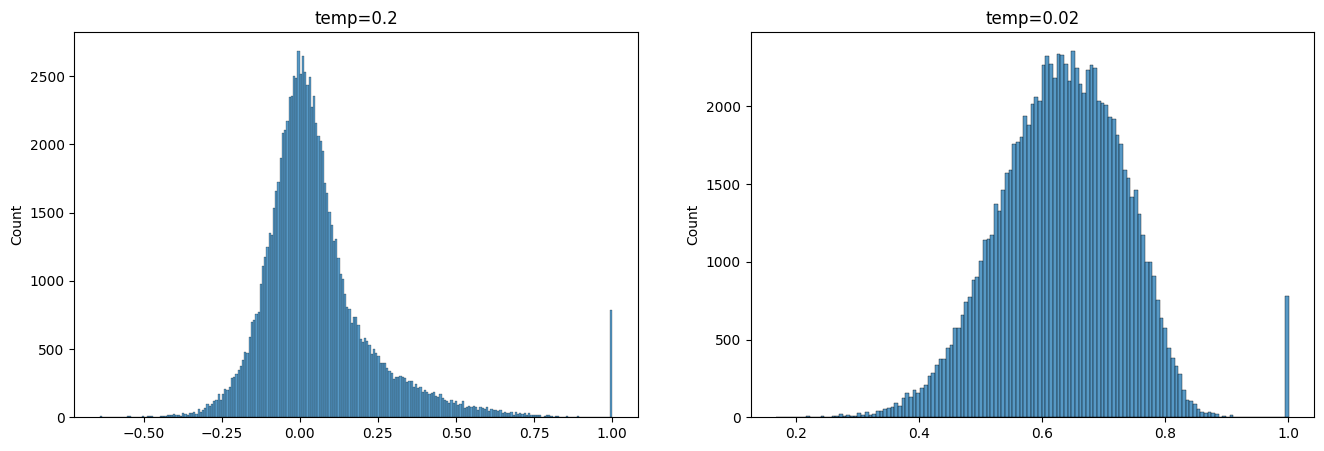

In [17]:
# check docsim figure

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

scores1 = torch.load("/opt/tiger/DouyinSearchEmb/data/results/docsim/qwen_2_0.5b-listwise-d64_2layer-v4-g2-bs256-fullparam-crossneg_8-temp0.2--checkpoint-6699/results.pt").flatten().numpy()
ax = sns.histplot(scores1[:100000], ax=axes[0])
ax.set_title("temp=0.2")

scores2 = torch.load("/opt/tiger/DouyinSearchEmb/data/results/docsim/qwen_2_0.5b-listwise-d64_2layer-v4-g2-bs256-fullparam-crossneg_8-temp0.02--checkpoint-6699/results.pt").flatten().numpy()
ax = sns.histplot(scores2[:100000], ax=axes[1])
ax.set_title("temp=0.02")

In [14]:
len(scores1)

12800000

In [ ]:
# check length distribution

MISSING_DOC_PLACEHOLDER = "NAN"

def process_fn(data, tokenizer):
    outputs = {"length": []}
    for pos, neg in zip(data["pos"], data["neg"]):
        if pos[0] != MISSING_DOC_PLACEHOLDER and neg[0] == MISSING_DOC_PLACEHOLDER:
            doc = pos[0]
        elif neg[0] != MISSING_DOC_PLACEHOLDER and pos[0] == MISSING_DOC_PLACEHOLDER:
            doc = neg[0]

        length = len(tokenizer.encode(doc))
        outputs["length"].append(length)
    return outputs

dataset = datasets.load_from_disk("/mnt/bn/search-douyin-rank-yg/all_data_from_lf/dataset/inhouse_data/pretrain_llm/trainset/search_query_doc_sample_v2_peitian/v2-train")
dataset = dataset.train_test_split(100000)["test"]
dataset = dataset.map(partial(process_fn, tokenizer=tokenizer), batched=True, num_proc=32, batch_size=32)

In [ ]:
lengths = np.array(dataset["length"])
TOTAL = len(lengths)

data = []
data.append({"length": "0~256", "portion": len(lengths[lengths<=256]) / TOTAL})
data.append({"length": "256~512", "portion": len(lengths[(256<lengths) * (lengths<=512)]) / TOTAL})
data.append({"length": "512~1024", "portion":  len(lengths[(512<lengths) * (lengths<=1024)]) / TOTAL})
data.append({"length": "1024~2048", "portion":  len(lengths[(1024<lengths) * (2048<=2048)]) / TOTAL})
data.append({"length": "2048+", "portion": len(lengths[2048<lengths]) / TOTAL})

data = pd.DataFrame(data)

sns.set(rc={'figure.figsize':(12, 5), "axes.titlesize":16, "axes.labelsize":14}, style="whitegrid", palette="colorblind")
ax = sns.barplot(data, x="length", y="portion")

In [ ]:
# check pointwise loss

scores = torch.tensor([0.1193]).expand(256 * 8)
labels = torch.zeros_like(scores)
# labels[:43] = 1

loss = torch.nn.functional.binary_cross_entropy(scores, labels)

loss

In [ ]:
# check binary cross-entropy

logits = torch.rand(2,3)
labels = torch.tensor([[1,0,1], [1,1,0]], dtype=logits.dtype)

In [ ]:
# check mixtral loss

import torch
from transformers import MixtralForCausalLM, MixtralConfig

config = MixtralConfig(num_hidden_layers=1, num_attention_heads=32, hidden_size=128, intermediate_size=128)
model = MixtralForCausalLM(config)
inputs = torch.tensor([[1,2,3,4,5]])

model(inputs, output_router_logits=True)

In [ ]:
# check similarity distribution

with open("/mnt/bn/search-douyin-rank-yg/all_data_from_lf/peitian_data/results.json") as f:
    logits = torch.tensor(json.load(f)["predictions"])

scores = torch.log(logits / (1 - logits))
sns.histplot(scores)